## Numerical Methods In Finance | fall 2024

### *Seminar 4*

In [39]:
import pandas as pd
import numpy as np
from typing import Union, Iterable
from scipy.stats import norm
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt
from py_vollib.black_scholes.implied_volatility import implied_volatility
implied_volatility_vectorized = np.vectorize(implied_volatility)

### 1. No arbitrage conditions for implied volatility interpolation

* The Black option formula can be written as 
$$
\text{Black}(F, K, \sigma, T, DF, \theta) = \text{DF} \cdot \theta \cdot \left[ F \cdot \Phi\left(- \theta \cdot \tfrac{\ln(K/F) - (\sigma^2/2) T}{\sigma \sqrt{T}}\right) - K \cdot \Phi\left(-\theta \cdot \tfrac{\ln{(K/F)} + (\sigma^2/2) T}{\sigma \sqrt{T}}\right) \right],
$$

&ensp;&emsp;&emsp; where $K$ and $T$ are strike and maturity of the option's contract, $DF$ and $F$ are discount factor and forward up to maturity $T$, $\sigma$ is the volatility and $\theta = \pm 1$ for calls/puts. 


&ensp;&emsp;&emsp; $\Phi(\cdot)$ is the cumulative density function of standard normal random variable. 

* Introducing new notations, it can be rewritten in the following way

$$
\text{Black}(F, K, \sigma, T, \text{DF}, \theta) = \text{DF} \cdot \theta \cdot F \cdot [\Phi(- \theta \cdot (\tfrac{z}{\sigma \sqrt{T}} - \tfrac{\sigma \sqrt{T}}{2})) - e^{z} \cdot \Phi(- \theta \cdot (\tfrac{z}{\sigma \sqrt{T}} + \tfrac{\sigma \sqrt{T}}{2}))],
$$

&ensp;&emsp;&emsp; where
$$z := \ln{(K/F)} \text{ is the log-moneyness. }$$

* When the volatility $\sigma$ is a function of strike $K$, that is $\sigma = \sigma(K)$, the first and the second derivative of the vanilla option price (assuming without loss of generality the time to expiration $T$ equal to $1$ and considering the undiscounted option prices, i.e. $DF = 1$)

$$v(K) := \text{Black}(F, K, \sigma(K), 1, 1, \theta)$$

&ensp;&emsp;&emsp; with respect to strike $K$ are 

$$v'(K) = K \cdot \phi(\tfrac{z}{\sigma} + \tfrac{\sigma}{2}) \cdot \sigma' - \theta \cdot \Phi(-\theta \cdot (\tfrac{z}{\sigma} + \tfrac{\sigma}{2})),$$
$$v''(K) = \frac{\phi(\tfrac{z}{\sigma} + \tfrac{\sigma}{2})}{4K\sigma^3} \cdot \left[ 4\sigma^2 + 4(\sigma^2-2z)K\sigma\sigma' + 4K^2\sigma^3\sigma'' + (4z^2-\sigma^4)K^2(\sigma')^2\right],$$

&ensp;&emsp;&emsp; where $\phi(\cdot)$ is the density function of standard normal random variable. 

* For there to be no arbitrage to be implied by the volatility function $\sigma(K)$, it is necessary for the second derivative, which is the risk-neutral *Bronzin-Breeden-Litzenberger* density 

$$\psi_{BBL} = v''(K)$$

&ensp;&emsp;&emsp; to be non-negative: 


\begin{equation}
\boxed{
\psi_{BBL} \geq 0.
}
\end{equation}



* Recasting equations above by the transformation

$$f(z):= \sigma(K)^2$$

&ensp;&emsp;&emsp; with notation 
$$\zeta := \dfrac{z}{\sqrt{f}} + \dfrac{\sqrt{f}}{2}$$

&ensp;&emsp;&emsp;  leads to 
$$v'(K) = \dfrac{f'}{2\sqrt{f}} \cdot \phi(\zeta) - \theta \cdot \Phi(-\theta \cdot \zeta),$$

$$v''(K) = \dfrac{\phi(\zeta)}{4K\sqrt{f}} \cdot \left[ 2f'' + \left(z \cdot \frac{f'}{f} - 2\right)^2  - f'^2 \left(\frac{1}{4} + \frac{1}{f}\right)\right],$$


\begin{align*}
v'''(K) = \dfrac{\phi(\zeta)}{K^2\sqrt{f}} \cdot [ &-\frac{3}{2} - \frac{3f''}{4} + \frac{f'''}{2} - \frac{f'}{8} - \frac{3f'}{2f} - \frac{3f''f'}{16} - \frac{3f''f'}{4f} + \frac{3f'^2}{32} + \frac{3f'^2}{8f} + \frac{f'^3}{128} + \frac{3f'^3}{8f^2} + \frac{f'^3}{16f} - \dfrac{z}{f} - \dfrac{3f''z}{f} + \\
&+ \dfrac{3f'z}{2f} + \dfrac{9f'^2z}{4f^2} + \dfrac{3f'^2z}{16f} + \dfrac{3f'z^2}{2f^2} + \dfrac{3f''f'z^2}{4f^2} - \dfrac{3f'^2z^2}{8f^2} - \dfrac{3f'^3z^2}{4f^3} - \dfrac{f'^3z^2}{16f^2} - \dfrac{3f'^2z^3}{4f^3} + \dfrac{f'^3z^4}{8f^4}].
\end{align*}

* In fact, the condition (1) for the denisty to be non negative, which immediately leads to 

$$2f'' + \left(z \cdot \frac{f'}{f} - 2\right)^2  - f'^2 \left(\frac{1}{4} + \frac{1}{f}\right) \geq 0$$

&ensp;&emsp;&emsp; on practice is effectively intractable as a constraint to any interpolant. For that reason, we are coming to the section below. 




### 2. Interpolation of option prices

* Consider the set of call option prices from the market. Let $C(K)$ be the corresponding price of the option struck at $K$. 

* For a given set of strike/price pairs $\{ (K_i, C_i) \}_{i=1}^{n}$ arbitrage is present in the data if for any $i$ either 

\begin{equation} \tag{2}
C_{i} > C_{i+1}
\end{equation}

&ensp;&emsp;&emsp; or 

\begin{equation} \tag{3}
\dfrac{C_{i-1}}{K_i - K_{i-1}} - C_i \cdot \left( \dfrac{1}{K_i - K_{i-1}} + \dfrac{1}{K_{i+1} - K_i} \right) + \dfrac{C_{i+1}}{K_{i+1}-K_i} \geq 0
\end{equation}

&ensp;&emsp;&emsp; fails to hold true. 

* In terms of interpolation $C(K)$ it means precisely that either of two conditions 

\begin{equation} \tag{4}
C' < 0, \qquad C'' \geq 0.
\end{equation}

&ensp;&emsp;&emsp; is violated.

* Obviously, the conditions above (that is, the conditions in $(K_i, C_i)$ coordinates) are much more tractable for an interpolation algorithm than the ones in $(z_i, f_i)$ coordinates from the previous section. 

* It is clear that any interpolation $C(K)$ method which, given strictly monotone and at least marginally convex
data $\{(K_i, C_i)\}$, preserves the conditions (4) and will by construction be free of arbitrage.

* Hence, the overall algorithm of implied volatility interpolation can be organized in the following way: 

&ensp;&emsp;&emsp; 1) Transform all input implied volatilities $\sigma(K_i)$ to call option prices $C_i$ for strikes above the forward $f$ and put option prices $P_i$ for strikes below the forward (to avoid roundoff truncation). 

$$\text{Black}(\dots, K_i, \sigma(K_i), \dots): \qquad  \sigma(K_i) \longmapsto v(K_i), \qquad i=1, \dots, n.$$

&ensp;&emsp;&emsp; 2) Interpolate on prices $\{K_i, v(K_i)\}$ using the interpolation method that preserves monotonicity and convexity. For this purpose, we employ the rational cubic
method of Delbourgo and Gregory **[DG85]**. 

&ensp;&emsp;&emsp; 3) Transform back prices to volatilites by implication. For that we need an efficient and accurate implied volatility function that works even extremely far away from the money. The industry-grade approach is to use the *Let's be rational* by Peter Jaeckel from **[Jac13]**. 

$$\text{Black}^{-1}(\dots, K, \sigma(K), \dots): \qquad v(K) \longmapsto  \sigma(K) \qquad \forall K.$$


### 3. Shape preserving rational cubic splines of Delbourgo and Gregory

Given the abscissa interval $[x_i, x_{i+1}]$ with boundary function values $\{f_i, f_{i+1}\}$ and associated slope values $\{ d_i, d_{i+1}\}$, the *rational cubic interpolation* formula of Delbourgo and Gregory is 

$$s(x) = \dfrac{P_i(\theta)}{Q_i(\theta)}, \qquad \theta = \dfrac{x - x_i}{x_{i+1} - x_i},$$

$$P_i(\theta) = f_{i+1} \theta^3 + (r_i f_{i+1} - h_i d_{i+1}) \theta^2 (1 - \theta) + (r_i f_i + h_i d_i) \theta (1 - \theta)^2 + f_i (1 - \theta)^3,$$

$$Q_i(\theta) = 1 + (r_i - 3)\theta (1 - \theta),$$

where $r_i > -1$ is a *suitably chosen cubic parameter*. 

In fact, the parameter $r$ can be selected in a such way to guarantee the monotonicity and convexity of the interpolant. More precisely, the interpolant is convex and insreasingly monotonic if under the assumption of 

$$0 \leq \pm d_1 < \pm \Delta_1 < \pm d_2 < \dots < \pm d_i < \pm \Delta_{i} < \dots < \pm d_n $$

where $\Delta_i = \dfrac{f_{i+1} - f_i}{x_{i+1} - x_i}$ and the sign $\pm 1$ depends on monotonicity (that is, equal to $+1$ if the data is monotonically increasing and $-1$ if monotonically decreasing),

$$r_i \geq \max \left \{ \dfrac{d_{i+1} - d_i}{d_{i+1} - \Delta_i}, \dfrac{d_{i+1} - d_i}{\Delta_i - d_i} \right \}.$$

Finally, usually we do not know exactly the slope values $d_i$, and therefore need to approximate them. One of the possible choices is the geometric mean approximation (which is $O(h^2)$)

$$d_i = \pm (\pm \Delta_{i-1})^{(x_{i+1} - x_i)/ (x_{i+1} - x_{i-1})} (\pm \Delta_{i})^{(x_i - x_{i-1})/ (x_{i+1} - x_{i-1})}, \quad i=2,\dots, n-1,$$

with end conditions

$$d_1 = \pm (\pm \Delta_1) ^{(x_3 - x_1)/ (x_3 - x_2)} (\pm \Delta_{3, 1})^{-(x_2 - x_1)/(x_3 - x_2)}, \qquad d_n = \pm (\pm\Delta_{n-1})^{(x_n - x_{n-2}) / (x_{n-1} - x_{n-2})} (\pm \Delta_{n, n-2})^{-(x_n - x_{n-1})/(x_{n-1} - x_{n-2})},$$
where 
$$\Delta_{3, 1} = \dfrac{f_3 - f_1}{x_3 - x_1}, \qquad \Delta_{n, n-2} = \dfrac{f_n - f_{n-2}}{x_n - x_{n-2}}$$
and the sign $\pm 1$ again depends on data monotonicity. 

In [77]:
def r_boundary(d: Iterable, f: Iterable, x: Iterable):
    r = []
    for i in range(len(x) - 1):
        Delta_i = (f[i + 1] - f[i]) / (x[i + 1] - x[i])
        r.append(max((d[i + 1] - d[i]) / (d[i + 1] - Delta_i), (d[i + 1] - d[i]) / (Delta_i - d[i])))
    return r

In [78]:
def d_1_approx(x_1: float, x_2: float, x_3: float, f_1: float, f_2: float, f_3: float):
    Delta_1 = - (f_2 - f_1) / (x_2 - x_1)
    Delta_31 = - (f_3 - f_1) / (x_3 - x_1)
    return - (Delta_1 ** ((x_3 - x_1) / (x_3 - x_2))) * (Delta_31 ** (-(x_2 - x_1) / (x_3 - x_2)))

In [79]:
def d_approx(x_1: float, x_2: float, x_3: float, f_1: float, f_2: float, f_3: float):
    Delta_1 = - (f_2 - f_1) / (x_2 - x_1)
    Delta_2 = - (f_3 - f_2) / (x_3 - x_2)
    return - (Delta_1 ** ((x_3 - x_2) / (x_3 - x_1))) * (Delta_2 ** ((x_2 - x_1) / (x_3 - x_1)))

In [80]:
def d_n_approx(x_n_2: float, x_n_1: float, x_n: float, f_n_2: float, f_n_1: float, f_n: float):
    Delta_n_1 = - (f_n - f_n_1) / (x_n - x_n_1)
    Delta_nn_2 = - (f_n - f_n_2) / (x_n - x_n_2)
    return - (Delta_n_1 ** ((x_n - x_n_2) / (x_n_1 - x_n_2))) * (Delta_nn_2 ** (-(x_n - x_n_1) / (x_n_1 - x_n_2)))

In [81]:
def slopes_estimation(x: list, y: list):
    slopes = []
    for i in range(len(x)):
        if i == 0:
            slopes.append(d_1_approx(x_1=x[i], x_2=x[i+1], x_3=x[i+2], f_1=y[i], f_2=y[i+1], f_3=y[i+2]))
        elif i == len(x) - 1:
            slopes.append(d_n_approx(x_n_2=x[i-2], x_n_1=x[i-1], x_n=x[i], f_n_2=y[i-2], f_n_1=y[i-1], f_n=y[i]))
        else:
            slopes.append(d_approx(x_1=x[i-1], x_2=x[i], x_3=x[i+1], f_1=y[i-1], f_2=y[i], f_3=y[i+1]))
    
    return slopes

In [82]:
class RationalCubicSplineInterpolator:
    def __init__(self, x, y, r, d):
        self._rationa_cubic_splines = []
        self.x = x
        for i in range(len(x) - 1):
            x_l, x_r = x[i], x[i + 1]
            y_l, y_r = y[i], y[i + 1]
            r_i = r[i]
            d_l, d_r = d[i], d[i + 1]
            self._rationa_cubic_splines.append(self.P_over_Q(x_l=x_l, x_r=x_r, y_l=y_l, y_r=y_r, d_l=d_l, d_r=d_r, r=r_i))

    def __call__(self, x):
        if isinstance(x, float):
            x = [x]
        output = []
        for x_ in x:
            if self.x[0] > x_:
                output.append(self._rationa_cubic_splines[0](x_))
            if self.x[-1] <= x_:
                output.append(self._rationa_cubic_splines[-1](x_))
            for i in range(len(self.x) - 1):
                if self.x[i] <= x_ < self.x[i + 1]:
                    output.append(self._rationa_cubic_splines[i](x_))
        return np.array(output)

    def P_over_Q(self, x_l: float, x_r: float, y_l: float, y_r: float, d_l: float, d_r: float, r: float):
        return lambda x: self.P(x_l=x_l, x_r=x_r, f_l=y_l, f_r=y_r, d_l=d_l, d_r=d_r, r=r)(x) / self.Q(x_l=x_l, x_r=x_r, r=r)(x)

    def P(self, x_l: float, x_r: float, f_l: float, f_r: float, d_l: float, d_r: float, r: float):
        h = (x_r - x_l)
        theta = lambda x: (x - x_l) / h
        return lambda x: f_r * (theta(x))**3 + (r * f_r - h * d_r) * (theta(x))**2 * (1 - theta(x)) + \
            (r * f_l + h * d_l) * (theta(x)) * (1 - theta(x))**2 + f_l * (1 - theta(x))**3
    
    def Q(self, x_l: float, x_r: float, r: float):
        h = (x_r - x_l)
        theta = lambda x: (x - x_l) / h
        return lambda x: 1 + (r - 3) * theta(x) * (1 - theta(x))



In [83]:
class CubicSplineInterpolator:
    def __init__(self, x, y, d):
        self._cubic_splines = []
        self.x = x
        for i in range(len(x) - 1):
            x_l, x_r = x[i], x[i + 1]
            y_l, y_r = y[i], y[i + 1]
            d_l, d_r = d[i], d[i + 1]
            self._cubic_splines.append(CubicSpline([x_l, x_r], [y_l, y_r], bc_type=((1, d_l), (1, d_r))))

    def __call__(self, x):
        if isinstance(x, float):
            x = [x]
        output = []
        for x_ in x:
            if self.x[0] > x_:
                output.append(self._cubic_splines[0](x_))
            if self.x[-1] <= x_:
                output.append(self._cubic_splines[-1](x_))
            for i in range(len(self.x) - 1):
                if self.x[i] <= x_ < self.x[i + 1]:
                    output.append(self._cubic_splines[i](x_))
        return np.array(output)
    
    def derivative(self, x, nu=1):
        if isinstance(x, float):
            x = [x]
        output = []
        for x_ in x:
            if self.x[0] > x_:
                output.append(self._cubic_splines[0].derivative(nu=nu)(x_))
            if self.x[-1] <= x_:
                output.append(self._cubic_splines[-1].derivative(nu=nu)(x_))
            for i in range(len(self.x) - 1):
                if self.x[i] <= x_ < self.x[i + 1]:
                    output.append(self._cubic_splines[i].derivative(nu=nu)(x_))
        return np.array(output)


**Example 1 (exact derivatives)**


$$f(x) = 1/x^2, \quad x_1 = 1, \quad x_2 = 2, \quad x_3 = 3$$
$$f_1 := f(x_1) = 1, \quad f_2 := f(x_2) = 1/4, \quad f_3 := f(x_3) = 1/9, \quad d_1:= f'(x_1) = -2, \quad d_2:= f'(x_2) = -1/4, \quad d_3 := f'(x_3) = -2/27.$$

In [84]:
x_1, x_2, x_3 = 1, 2, 3
f_1, f_2, f_3 = 1, 1/4, 1/9
d_1, d_2, d_3  = -2, -1/4, -2/27

In [85]:
r = r_boundary(d=[d_1, d_2, d_3], f=[f_1, f_2, f_3], x=[x_1, x_2, x_3])
print("Lower boundaries for r_i: {}".format(r))

Lower boundaries for r_i: [3.5, 2.714285714285714]


In [86]:
x = np.linspace(x_1, x_3, 100)

# Defining the objective function f(x) 
f = lambda x: 1 / x ** 2
# Defining the rational cubic spline interpolators 
rational_cubic_s = RationalCubicSplineInterpolator(x=[x_1, x_2, x_3], y=[f_1, f_2, f_3], r=r, d=[d_1, d_2, d_3])
# Defining the natural cubic spline interpolators
natural_cubic_s = CubicSplineInterpolator(x=[x_1, x_2, x_3], y=[f_1, f_2, f_3], d=[d_1, d_2, d_3])

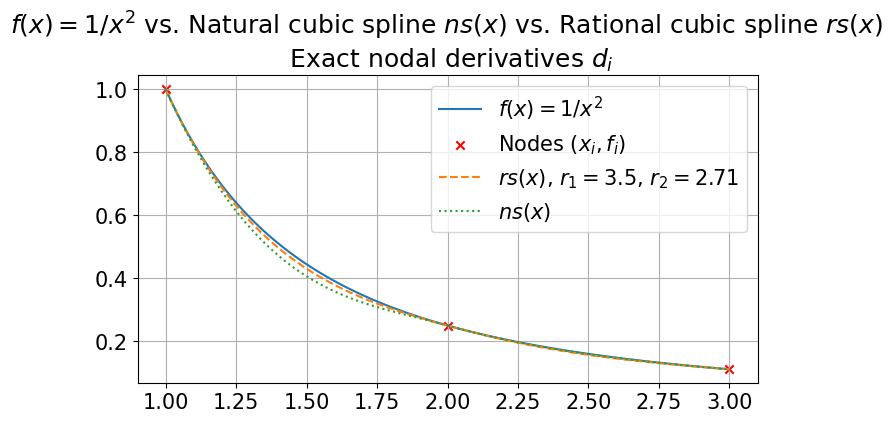

In [87]:
plt.figure(figsize=(8, 4))
plt.plot(x, f(x), label="$f(x)=1/x^2$")
plt.scatter(x=[x_1, x_2, x_3], y=[f_1, f_2, f_3], marker="x", color="red", label="Nodes $(x_i, f_i)$")
plt.plot(x, rational_cubic_s(x), label="$rs(x)$, $r_1=${}, $r_2=${}".format(round(r[0], 2), round(r[1], 2)), linestyle="--")
plt.plot(x, natural_cubic_s(x), label="$ns(x)$", linestyle=":")
plt.title('$f(x) = 1/x^2$ vs. Natural cubic spline $ns(x)$ vs. Rational cubic spline $rs(x)$ \n Exact nodal derivatives $d_i$')
plt.legend()
plt.grid(True)
plt.show()

**Example 2 (approximated derivatives)**


$$f(x) = 1/x^2, \quad x_1 = 1, \quad x_2 = 2, \quad x_3 = 3$$
$$f_1 := f(x_1) = 1, \quad f_2 := f(x_2) = 1/4, \quad f_3 := f(x_3) = 1/9.$$

$$d_1 = \Delta_1 ^{(x_3 - x_1)/ (x_3 - x_2)} \Delta_{3, 1}^{-(x_2 - x_1)/(x_3 - x_2)}, \qquad d_n = \Delta_{n-1}^{(x_n - x_{n-2}) / (x_{n-1} - x_{n-2})} \Delta_{n, n-2}^{-(x_n - x_{n-1})/(x_{n-1} - x_{n-2})},$$

$$d_1 = \Delta_1 ^{(x_3 - x_1)/ (x_3 - x_2)} \Delta_{3, 1}^{-(x_2 - x_1)/(x_3 - x_2)}, \qquad d_2 = \Delta_{1}^{(x_{3} - x_2)/ (x_{3} - x_{2})} \Delta_{2}^{(x_2 - x_{1})/ (x_{2} - x_{1})}, \qquad d_3 = \Delta_{2}^{(x_3 - x_{1}) / (x_{2} - x_{1})} \Delta_{3, 1}^{-(x_3 - x_{2})/(x_{2} - x_{1})}.$$


In [88]:
x_1, x_2, x_3 = 1, 2, 3
f_1, f_2, f_3 = 1, 1/4, 1/9
d_1, d_2, d_3 = slopes_estimation(x=[x_1, x_2, x_3], y=[f_1, f_2, f_3])

In [89]:
r = r_boundary(d=[d_1, d_2, d_3], f=[f_1, f_2, f_3], x=[x_1, x_2, x_3])
print("Lower boundaries for r_i: {}".format(r))

Lower boundaries for r_i: [2.2068421887069456, 2.9255127385082913]


In [90]:
x = np.linspace(x_1, x_3, 100)

# Defining the objective function f(x) 
f = lambda x: 1 / x ** 2
# Defining the rational cubic spline interpolators 
rational_cubic_s = RationalCubicSplineInterpolator(x=[x_1, x_2, x_3], y=[f_1, f_2, f_3], r=r, d=[d_1, d_2, d_3])
# Defining the natural cubic spline interpolators
natural_cubic_s = CubicSplineInterpolator(x=[x_1, x_2, x_3], y=[f_1, f_2, f_3], d=[d_1, d_2, d_3])

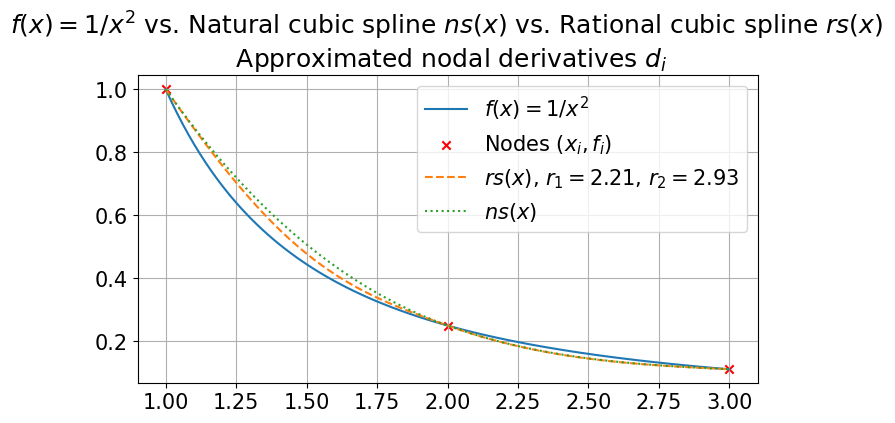

In [91]:
plt.figure(figsize=(8, 4))
plt.plot(x, f(x), label="$f(x)=1/x^2$")
plt.scatter(x=[x_1, x_2, x_3], y=[f_1, f_2, f_3], marker="x", color="red", label="Nodes $(x_i, f_i)$")
plt.plot(x, rational_cubic_s(x), label="$rs(x)$, $r_1=${}, $r_2=${}".format(round(r[0], 2), round(r[1], 2)), linestyle="--")
plt.plot(x, natural_cubic_s(x), label="$ns(x)$", linestyle=":")
plt.title('$f(x) = 1/x^2$ vs. Natural cubic spline $ns(x)$ vs. Rational cubic spline $rs(x)$ \n Approximated nodal derivatives $d_i$')
plt.legend()
plt.grid(True)
plt.show()

### 4. Option prices interpolation

In [92]:
def black(log_moneyness: Union[float, np.ndarray], forward: float, vol: Union[np.ndarray, float], 
          df: float = 1, T: float = 1, theta: float = 1) -> Union[float, np.ndarray]:
    total_vol = vol * np.sqrt(T)
    d_1 = - theta * (log_moneyness / total_vol - total_vol / 2)
    d_2 = - theta * (log_moneyness / total_vol + total_vol / 2)   
    return df * theta * forward * (norm.cdf(d_1) - np.exp(log_moneyness) * norm.cdf(d_2))

Hereinafter, without loss of generality, we set the time to expiry $T$ to $1$ ass well as the forward value $F$ and the discount factor $DF$. 

In [93]:
vols_wide_range = pd.read_csv("vols_wide_range.csv", delimiter=";")
moneyness_wide_range = vols_wide_range["K/F"].values.astype(float)
vol_wide_range = vols_wide_range["vol"].values.astype(float)

In [94]:
forward, df, T = 1.0, 1.0, 1.0
calls_wide_range = black(log_moneyness=np.log(moneyness_wide_range),
                          forward=forward, 
                          vol=vol_wide_range,
                          df=df, T=T, theta=1)

In [95]:
calls_wide_range

array([9.75000000e-01, 9.60000001e-01, 9.26000197e-01, 9.00000355e-01,
       8.75000885e-01, 8.12509071e-01, 7.40044042e-01, 6.30279070e-01,
       4.81906466e-01, 3.11941761e-01, 9.94764497e-02, 1.00049571e-02,
       1.61721035e-04, 1.34467201e-07, 4.90399238e-11, 3.83313116e-16,
       5.01951459e-22, 6.86171114e-29])

To check the discrete data $\{ (K_i, C_i) \}_{i=1}^n$ on arbitrage, we need to check the conditions $(2)$ and $(3)$.

In [96]:
def monotonicity_arbitrage(c: np.ndarray, k: np.ndarray):
    arbitrage_detected = False
    for i in range(len(c) - 1):
        if c[i + 1] >= c[i]:
            print("A monotonicity arbitrage was detected with strikes {} and {}".format(k[i],k[i+1]))
            arbitrage_detected = True
            
    if not arbitrage_detected:
        print("No arbitrage was detected.")


In [97]:
def convexity_arbitrage(c: np.ndarray, k: np.ndarray):
    arbitrage_detected = False
    for i in range(1, len(c) - 1):
        check_to = c[i-1] / (k[i] - k[i-1]) - c[i] * (1/(k[i] - k[i-1]) + 1/(k[i+1] - k[i])) + c[i+1] / (k[i+1] - k[i]) 
        if check_to < 0:
            print("A convexity arbitrage was detected with strikes {}, {} and {}".format(k[i-1], k[i], k[i+1]))
            arbitrage_detected = True

    if not arbitrage_detected:
        print("No arbitrage was detected.")

In [98]:
monotonicity_arbitrage(c=calls_wide_range, k=moneyness_wide_range*forward)

No arbitrage was detected.


In [99]:
convexity_arbitrage(c=calls_wide_range, k=moneyness_wide_range*forward)

No arbitrage was detected.


* To retreive implied vols $\sigma(K_i)$ from prices, we use, as it was mentioned above, the *Let's be rational* algorithm. 

* To avoid round off truncation error, for strikes below the forward $F$ we use OTM put options, for strikes above forward - OTM call options. Switch from calls to puts can be done within put-call parity: 

$$PV^{Call} - PV^{Put} = DF \cdot (F - K)$$

In [100]:
def implied_volatility(prices: Union[np.ndarray, float], T: float, K: Union[np.ndarray, float],
                       forward: float, type="calls", df: float = 1.0, r: float = 0.0):
    if isinstance(K, float):
        flags = 'c' if K > forward else 'p'
        
    elif isinstance(K, np.ndarray):
        calls_indicators = (K[:-1] + K[1:]) * 0.5 >= 1
        calls_indicators = np.append(calls_indicators, True)
        thetas = 2 * calls_indicators - 1
        flags = np.vectorize(lambda x: "c" if x == 1.0 else "p")(thetas)
        if type == "calls":
            prices[~calls_indicators] = prices[~calls_indicators] - df * (forward - K[~calls_indicators])
        elif type == 'puts':
            prices[calls_indicators] = prices[calls_indicators] + df * (forward - K)
            
    return implied_volatility_vectorized(price=prices, S=forward, K=K,
                                         t=T, r=r, flag=flags)

In [101]:
dense_grid = np.linspace(moneyness_wide_range[0], moneyness_wide_range[-1], 50)
dense_grid = np.unique(np.append(dense_grid, moneyness_wide_range[:-1]))
dense_grid

array([ 0.025     ,  0.04      ,  0.074     ,  0.1       ,  0.125     ,
        0.1875    ,  0.23673469,  0.26      ,  0.37      ,  0.44846939,
        0.52      ,  0.66020408,  0.7       ,  0.87193878,  1.        ,
        1.08367347,  1.29540816,  1.375     ,  1.50714286,  1.71887755,
        1.9       ,  1.93061224,  2.14234694,  2.35408163,  2.56581633,
        2.75      ,  2.77755102,  2.98928571,  3.20102041,  3.4127551 ,
        3.6244898 ,  3.75      ,  3.83622449,  4.04795918,  4.25969388,
        4.47142857,  4.68316327,  4.89489796,  5.10663265,  5.31836735,
        5.375     ,  5.53010204,  5.74183673,  5.95357143,  6.16530612,
        6.37704082,  6.58877551,  6.8005102 ,  7.0122449 ,  7.22397959,
        7.43571429,  7.5       ,  7.64744898,  7.85918367,  8.07091837,
        8.28265306,  8.49438776,  8.70612245,  8.91785714,  9.12959184,
        9.34132653,  9.55306122,  9.76479592,  9.97653061, 10.18826531,
       10.4       ])

Estimate slopes of call prices $C(K_i)$ at given strikes $K_i$.

In [102]:
calls_slopes = slopes_estimation(x=moneyness_wide_range, y=calls_wide_range)

In [103]:
r = r_boundary(d=calls_slopes, f=calls_wide_range, x=moneyness_wide_range)

In [107]:
r

[np.float64(2.0000008735424126),
 np.float64(22.892304659809653),
 np.float64(56.85370511647891),
 np.float64(5.2208297927169225),
 np.float64(3.07565639772112),
 np.float64(4.484481795224832),
 np.float64(4.707465372265243),
 np.float64(5.119597187095947),
 np.float64(4.984160417640133),
 np.float64(2.946791893004731),
 np.float64(2.270471612870509),
 np.float64(5.124000863242265),
 np.float64(17.681616566954123),
 np.float64(52.565417768446856),
 np.float64(182.43999319164718),
 np.float64(914.5797277386547),
 np.float64(2971.9023387628963)]

Given option prices and corresponding slope estimates, construct rational cubic spline interpolator of option prices. 

In [104]:
interpolated_calls_rs = RationalCubicSplineInterpolator(x=moneyness_wide_range, y=calls_wide_range, r=r, d=calls_slopes)

Transform option prices to implied vols Black formula inversion. 

In [105]:
implied_vols_via_rs_prices_interpolation = implied_volatility(prices=interpolated_calls_rs(dense_grid), T=T, K=dense_grid * forward, forward=forward, type="calls", df=df)

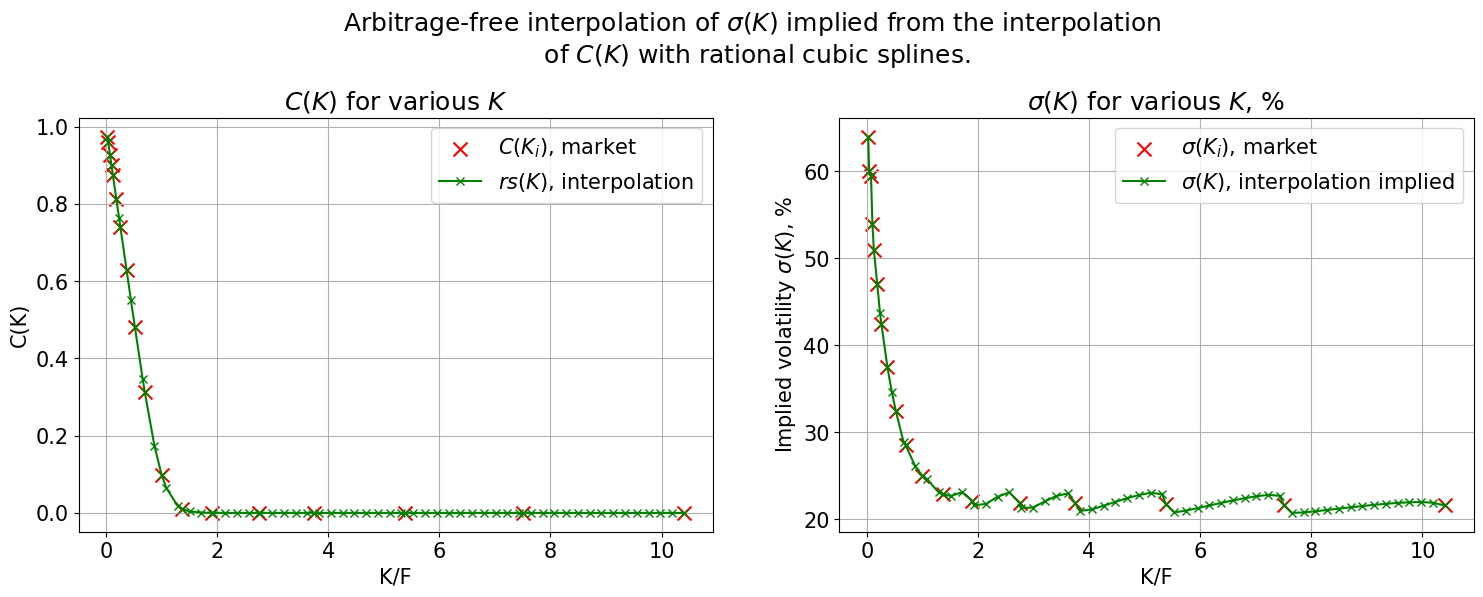

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plt.rcParams.update({'font.size': 15, "axes.labelsize": 15})

ax[0].scatter(moneyness_wide_range, calls_wide_range, label="$C(K_i)$, market", marker="x", color="red", s=100)
ax[0].plot(dense_grid, interpolated_calls_rs(dense_grid), label="$rs(K)$, interpolation", marker="x", color="green")
ax[1].scatter(moneyness_wide_range, vol_wide_range * 100, label="$\sigma(K_i)$, market", marker="x", color="red", s=100)
ax[1].plot(dense_grid, implied_vols_via_rs_prices_interpolation * 100, label="$\sigma(K)$, interpolation implied", marker="x", color="green")

plt.suptitle("Arbitrage-free interpolation of $\sigma(K)$ implied from the interpolation \n of $C(K)$ with rational cubic splines.")
plt.subplots_adjust(top=0.8)
ax[0].set_title('$C(K)$ for various $K$'), ax[0].set_xlabel('K/F'), ax[0].set_ylabel('C(K)'), ax[0].legend()
ax[1].set_title('$\sigma(K)$ for various $K$, %'), ax[1].set_xlabel('K/F'), ax[1].set_ylabel('Implied volatility $\sigma(K)$, %'), ax[1].legend()
ax[0].grid(), ax[1].grid()
plt.show()

* Intriguingly, we see that there appear some waves when comparing to a conventional smooth implied volatility interpolation.

* In fact, the generated waves are not an artefact of the choice of price interpolation method. 

* Clearly, such spurious oscilattions are totally indesirable, especially when implied volatility should be nearly flat for large strikes. 

* Therefore, despite the fact that shape-preserving interpolation of prices is workable, it can be outright ugly, and would not be acceptable to any trading practitioner.

### 5. Implied volatilities interpolation

Estimate slopes of implied volatilities $\sigma(K_i)$ at given strikes $K_i$.

In [113]:
ivs_slopes = slopes_estimation(x=np.log(moneyness_wide_range), y=vol_wide_range)

Given implied volatilities and corresponding slope estimates, construct cubic splines interpolator of implied vols. 

In [114]:
interpolated_vols = CubicSplineInterpolator(x=np.log(moneyness_wide_range), y=vol_wide_range, d=ivs_slopes)
interpolated_vols_dense_grid = interpolated_vols(np.log(dense_grid))

Transform the implied vols to option prices within Black formula. 

In [115]:
interpolated_calls_ns_via_vols_interpolation = black(log_moneyness=np.log(dense_grid), 
                                                     forward=forward, vol=interpolated_vols_dense_grid,
                                                     df=df, T=T, theta=1)

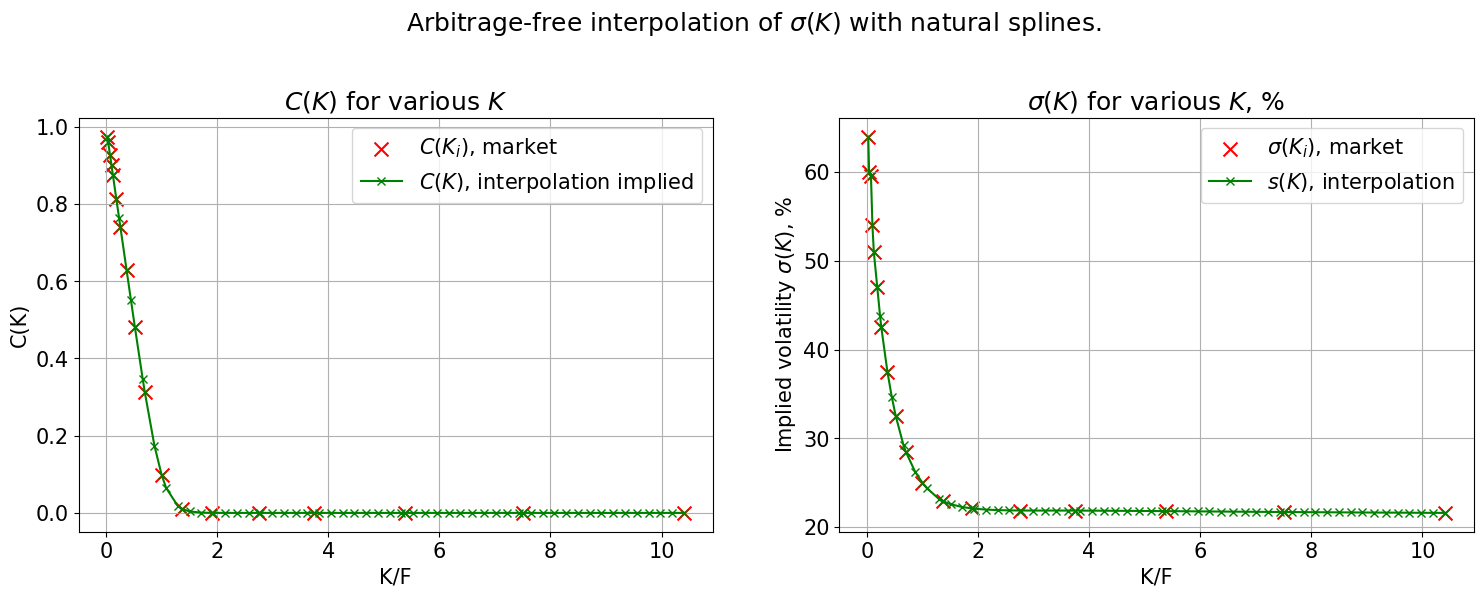

In [116]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plt.rcParams.update({'font.size': 15, "axes.labelsize": 15})

ax[0].scatter(moneyness_wide_range, calls_wide_range, label="$C(K_i)$, market", marker="x", color="red", s=100)
ax[0].plot(dense_grid, interpolated_calls_ns_via_vols_interpolation, label="$C(K)$, interpolation implied", marker="x", color="green")
ax[1].scatter(moneyness_wide_range, vol_wide_range * 100, label="$\sigma(K_i)$, market", marker="x", color="red", s=100)
ax[1].plot(dense_grid, interpolated_vols_dense_grid * 100, label="$s(K)$, interpolation", marker="x", color="green")

plt.suptitle("Arbitrage-free interpolation of $\sigma(K)$ with natural splines.")
plt.subplots_adjust(top=0.8)
ax[0].set_title('$C(K)$ for various $K$'), ax[0].set_xlabel('K/F'), ax[0].set_ylabel('C(K)'), ax[0].legend()
ax[1].set_title('$\sigma(K)$ for various $K$, %'), ax[1].set_xlabel('K/F'), ax[1].set_ylabel('Implied volatility $\sigma(K)$, %'), ax[1].legend()
ax[0].grid(), ax[1].grid()
plt.show()

What about arbitrage? Does implied volatilities interpolation guarantee an absence of arbitrage?

In [117]:
def breeden_litzenberger_density(f: Union[np.ndarray, float], df_dlogm: Union[np.ndarray, float], d2f_dlogm2: Union[np.ndarray, float], 
                                 moneyness: Union[np.ndarray, float], forward: float):
    z = np.log(moneyness)
    zeta = z / np.sqrt(f) + np.sqrt(f) / 2
    K = moneyness * forward
    return norm.pdf(zeta) / (4 * K * np.sqrt(f)) * (2 * d2f_dlogm2 + (z * df_dlogm / f - 2) ** 2 - (df_dlogm) ** 2 * (1 / 4 + 1 / f))

In [118]:
df_dlogm = interpolated_vols.derivative(x=np.log(dense_grid), nu=1)
d2f_dlogm2 = interpolated_vols.derivative(x=np.log(dense_grid), nu=2)

In [119]:
density = breeden_litzenberger_density(f=interpolated_vols_dense_grid, df_dlogm=df_dlogm, d2f_dlogm2=d2f_dlogm2, moneyness=dense_grid, forward=forward)

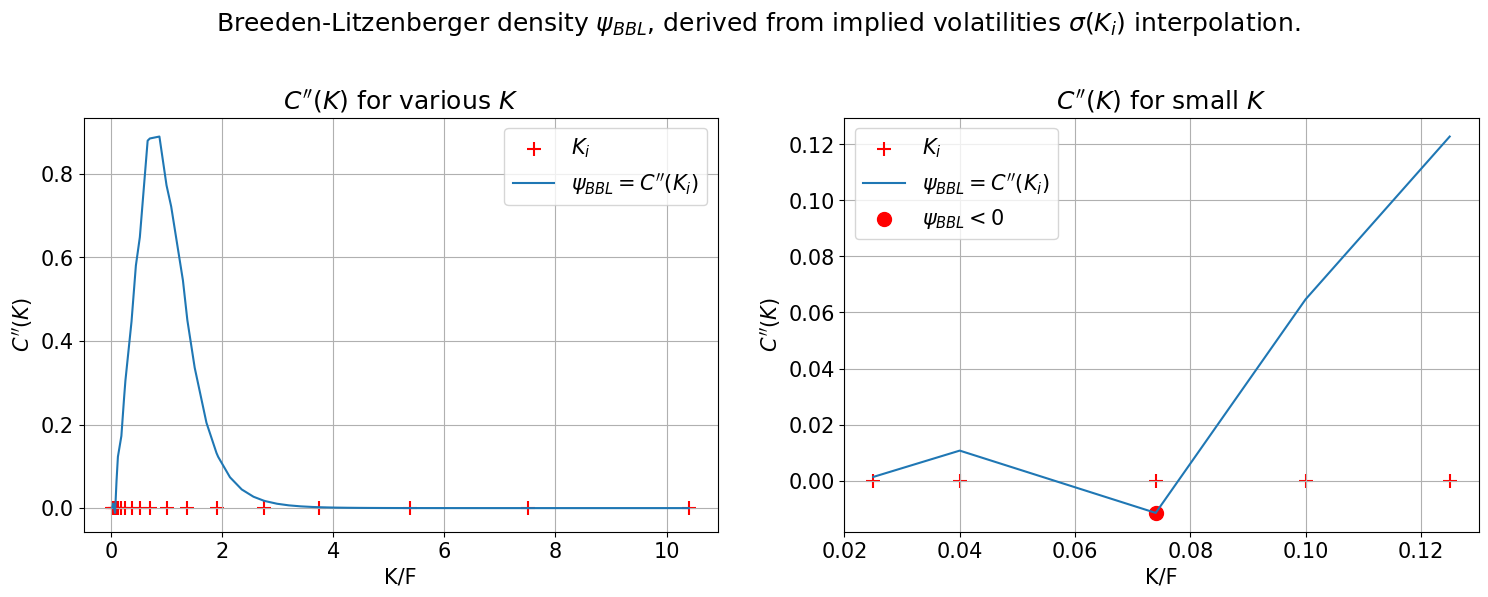

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plt.rcParams.update({'font.size': 15, "axes.labelsize": 15})

ax[0].scatter(moneyness_wide_range, np.zeros_like(moneyness_wide_range), label="$K_i$", marker="+", color="red", s=100)
ax[0].plot(dense_grid, density, label="$\psi_{BBL} = C''(K_i)$")
ax[1].scatter(moneyness_wide_range[:5], np.zeros_like(moneyness_wide_range[:5]), label="$K_i$", marker="+", color="red", s=100)
ax[1].plot(dense_grid[:5], density[:5], label="$\psi_{BBL} = C''(K_i)$")
ax[1].scatter(dense_grid[2], density[2], label="$\psi_{BBL} < 0$", marker="o", color="red", s=100)

plt.suptitle("Breeden-Litzenberger density $\psi_{BBL}$, derived from implied volatilities $\sigma(K_i)$ interpolation.")
plt.subplots_adjust(top=0.8)
ax[0].set_title('$C\'\'(K)$ for various $K$'), ax[0].set_xlabel('K/F'), ax[0].set_ylabel('$C\'\'(K)$'), ax[0].legend()
ax[1].set_title('$C\'\'(K)$ for small $K$'), ax[1].set_xlabel('K/F'), ax[1].set_ylabel('$C\'\'(K)$'), ax[1].legend()
ax[0].grid(), ax[1].grid()
plt.show()

+ We see that natural cubic spline interpolation of $f(z)$ leads to negative Breeden-Litzenberger densities. 

+ The respective range of negative densities appear far from the money,  but for the valuation of exotic contracts that need to be calibrated
to all strikes, this is a real problem.

+  Since the direct interpolation of $f(z)$ provides no guarantee whatsoever that it does not generate spurious arbitrage: this could happen anywhere!

### 6. Clamping down on arbitrage

In fact, to avoid arbitrage and satisfy all other (both financial and not) criterias, one may combine the interpolation of prices and implied vols. That is, the process is the following: 


1. Build an implied volatility interpolator $f(z)$ based on interpolation of variances $\sigma^2 \cdot T$ over $z := \ln{(K/F)}$ with $\sigma(K) = \sqrt{f(\ln{(K/F)})/T}$. This interpolator $f(z)$ is a cubic spline. 

2. Detect intervals with negative densities and call them density-deffective. 

3. For each density-deffective interval, implied volatilties will be computed by interpolation of **prices** $C(K)$. To do this, build rational
cubic interpolators of (out-of-the-money) prices with the geometric mean method of choosing the slopes at interpolation interval boundaries to preserve monotonicity and convexity.

4. For any density-defective interval $I_i$, compute analytically the boundary slopes $d_i$ and $d_{i+1}$ of the price function from the variance interpolator $f(z)$, and impose those slopes on the price interpolator. Note that this configures the subsequent price interpolation to have slopes on the interval boundaries consistent with the slopes of the original volatility/variance interpolator. This is the key to the appearance of smoothness! Also store the straight line interval slope values

$$\Delta_{i} := \dfrac{C(K_{i+1}) - C(K_i)}{K_{i+1} - K_i},$$

&ensp;&emsp;&emsp; which should satisfy convexity condition

$$d_{i} \leq \Delta_{i} \leq d_{i+1}.$$

&ensp;&emsp;&emsp; If the convexity condition is not met, say, $d_i > \Delta_i$, then set $d_i$ to the value from the unconstrained price interpolator.

5. On interval $I_i$, now interpolate prices with the so chosen lateral slope values $d_i$ and $d_{i+1}$ with rational cubic interpolation. Imply volatilities from the so obtained prices

6. Rebuild the variance interpolator $f(z)$, if it supports internal clamping, with an override of boundary slopes at those locations where the above procedure effectively resulted in overrides of the respective $d_i$ values. When this happens, we need to repeat the check for defective intervals since this last step can sometimes reintroduce negative densities on other intervals. If any additional intervals are found to be defective, the above ironing-out algorithm needs to be repeated. In principle, it is possible for this to result in an iteration until all intervals are interpolated by prices, but this should only happen for totally corrupt input data.

### References

1. Jaeckel, Peter. (2014). Clamping Down on Arbitrage. *Wilmott*. 2014. 10.1002/wilm.10329. 

2. Delbourgo, Robert and J. A. Gregory. “Shape Preserving Piecewise Rational Interpolation.” *Siam Journal on Scientific and Statistical Computing* 6 (1985): 967-976.

3. https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html